In [47]:
import numpy as np
import pandas as pd
import warnings
import random


from globalbonds.dataio.data_lib import DataLib
from globalbonds.indicators.data_utils import *
from globalbonds.indicators.signal import Signal
from globalbonds.indicators.indicator import Indicator
from globalbonds.indicators.assess_signal import predictive_accuracy
from globalbonds.indicators.return_utils import *
from globalbonds.indicators.normalization import *


from plotnine import *

from scipy.stats import pearsonr, spearmanr
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC

warnings.filterwarnings('ignore')


COUNTRIES = ['USA', 'JPN', 'AUS', 'DEU']
COUNTRIES = ['JPN', 'CAN', 'ESP', 'DEU', 'ITA', 'GBR', 'NOR', 'AUS', 'USA', 'SWE']
dlib = DataLib('../SignalData')
START_DATE = '1983-01-01'
END_DATE = '2010-01-01'
END_DATE = '2020-01-01'




def sharpe_ratio(bond_returns, cash_rate, signal, signal_weights=1):
    """Return the Sharpe ratio for a signal."""
    signal = signal.copy().fillna(0)
    bond_returns = bond_returns.pct_change()
    signal_returns = bond_returns * signal
    signal_returns = signal_returns.sum(axis=1) 
    signal_returns -= cash_rate
    signal_returns *= signal_weights
    sharpe = signal_returns.mean() / signal_returns.std()
    return sharpe


def calc_signal_risk_adj_returns(bond_returns, cash_rate, signal, signal_weights=1):
    """Return a Series of returns (as fraction of initial investment) for a signal."""
    signal = signal.copy().fillna(0)
    bond_returns = bond_returns.pct_change()
    signal_returns = bond_returns * signal
    signal_returns = signal_returns.sum(axis=1) 
    signal_returns -= cash_rate
    signal_returns *= signal_weights
    signal_returns += 1
    signal_returns = signal_returns.cumprod()
    return signal_returns


def get_passive_return(bond_returns, cash_rate):
    risk_free_returns = bond_returns['USA'].pct_change() + 1
    risk_free_returns /= (1 + cash_rate)
    risk_free_returns = risk_free_returns.cumprod()
    return risk_free_returns


def mask(tbl):
    tbl = tbl[COUNTRIES]
    tbl = tbl.loc['1980-01-01':END_DATE]
    return tbl

def get_setup(dlib, mask, start_date, end_date):
    bond_returns = mask(dlib.pull('BondRetIdx-LocalFX')).resample('M').mean()
    cash_rate = get_cash_rate(dlib)
    optimal_returns = calc_signal_risk_adj_returns(bond_returns, cash_rate, get_optimal_signal(bond_returns))
    optimal_returns = optimal_returns.loc[start_date: end_date]
    passive_10yrs = get_passive_return(bond_returns, cash_rate)
    passive_10yrs = passive_10yrs.loc[start_date: end_date]
    bond_returns = bond_returns.loc[start_date: end_date]
    cash_rate = cash_rate.loc[start_date: end_date]
    return bond_returns, cash_rate, optimal_returns, passive_10yrs

bond_returns, cash_rate, optimal_returns, passive_10yrs = get_setup(dlib, mask, START_DATE, END_DATE)

dlib.list()

['GDP-Real',
 'EquityPrices',
 'LongRates',
 'CurrAcctNom-inUSD',
 'CoreCPI-SA',
 'fxTrdWts-Real',
 'M3-inUSD',
 'RiskFree-Rate',
 'CurrAcctPctGDP',
 'fxTrdWts-Nominal',
 'BondRetIdx-LocalFX',
 'fxVsUSD',
 'M2-inUSD',
 'M1-inUSD',
 'ShortRates',
 'GDP-Nominal']

In [29]:
# Momentum

def get_momentum(bond_returns, start_date, end_date):
    momentum_sig = get_momentum_signal(bond_returns, window=12)
    momentum_sig += get_momentum_signal(bond_returns, window=36)
    momentum_sig = momentum_sig.loc[start_date:end_date]
    momentum_sig = signalize(momentum_sig).fillna(0)
    momentum_returns = calc_signal_risk_adj_returns(bond_returns, cash_rate, momentum_sig)
    print('Net Momentum RAR', momentum_returns.iloc[-1])
    return momentum_sig, momentum_returns

momentum_sig, momentum_returns = get_momentum(bond_returns, START_DATE, END_DATE)

Net Momentum RAR 1.9266483464224644


In [45]:
# Growth

def get_growth(dlib, mask, start_date, end_date):
    gdp = mask(dlib.pull('GDP-Real'))
    gdp = gdp.resample('M').pad()
    gdp = derivative(gdp, s=1).rolling(3).mean()
    gdp = center_scale_using_historical_rolling(gdp, window=24, gap=1)
    gdp_sig = signalize(gdp).fillna(0)
    gdp_sig = gdp_sig.loc[start_date:end_date]
    gdp_returns = calc_signal_risk_adj_returns(bond_returns, cash_rate, gdp_sig)
    print('Net GDP RAR', gdp_returns.iloc[-1])

    eqs = mask(dlib.pull('EquityPrices'))
    eqs = eqs.resample('M').mean()
    eqs = eqs.rolling(12).apply(lambda x: x[11] / x[:11].max()).applymap(lambda x: x - 1)
    eqs_sig = signalize(eqs).fillna(0)
    eqs_sig = eqs_sig.loc[start_date:end_date]
    eqs_returns = calc_signal_risk_adj_returns(bond_returns, cash_rate, eqs_sig)
    print('Net Equity RAR', eqs_returns.iloc[-1])

    pick_gdp = gdp_sig.apply(extremity, axis=1) > eqs_sig.apply(extremity, axis=1)
    print('GDP Picks (%)', 100 * pick_gdp.sum() / pick_gdp.shape[0])
    growth_sig = eqs_sig.copy()
    growth_sig[pick_gdp] = gdp_sig[pick_gdp]

    growth_returns = calc_signal_risk_adj_returns(bond_returns, cash_rate, growth_sig)
    print('Net Growth RAR', growth_returns.iloc[-1])
    return growth_sig, growth_returns

growth_sig, growth_returns = get_growth(dlib, mask, START_DATE, END_DATE)

Net GDP RAR 0.15878142959003094
Net Equity RAR 0.4962585201411268
GDP Picks (%) 17.078651685393258
Net Growth RAR 0.2813891373655335


In [31]:
# Inflation
def get_inflation(dlib, mask, start_date, end_date):
    m2 = mask(dlib.pull('M2-inUSD'))
    m2_3m = m2.rolling(3).mean()
    m2_12m = m2.rolling(12).mean()
    m2 = m2_3m / m2_12m
    m2 = center_scale_using_historical_rolling(m2, window=6, gap=1)
    m2_sig = signalize(m2).fillna(0)
    m2_sig = m2_sig.loc[start_date:end_date]
    m2_returns = calc_signal_risk_adj_returns(bond_returns, cash_rate, m2_sig)
    print('Net M2 RAR', m2_returns.iloc[-1])

    cpi = mask(dlib.pull('CoreCPI-SA'))
    cpi = derivative(cpi, s=3)
    cpi = -cpi
    cpi = center_scale_using_historical_rolling(cpi, window=6, gap=1)
    cpi_sig = signalize(cpi).fillna(0)
    cpi_sig = cpi_sig.loc[start_date:end_date]
    cpi_returns = calc_signal_risk_adj_returns(bond_returns, cash_rate, cpi_sig)
    print('Net CPI RAR', cpi_returns.iloc[-1])

    fx = mask(dlib.pull('fxVsUSD'))
    fx['USA'] = 1 / fx.drop(columns='USA').mean(axis=1)
    W = 2
    fx = fx.rolling(W).apply(lambda x: x[W - 1] / x[:W - 1].mean())
    fx = derivative(fx, s=6)
    fx = fx.applymap(lambda x: 1 / x)
    fx_sig = signalize(fx.resample('M').mean()).fillna(0)
    fx_sig = fx_sig.loc[start_date:end_date]
    fx_returns = calc_signal_risk_adj_returns(bond_returns, cash_rate, fx_sig)
    print('Net FX RAR', fx_returns.iloc[-1])

    inflation_sig = signalize(2 * fx_sig + 1 * cpi_sig + 2 * m2_sig)
    inflation_returns = calc_signal_risk_adj_returns(bond_returns, cash_rate, inflation_sig)
    print('Net Inflation RAR', inflation_returns.iloc[-1])
    return inflation_sig, inflation_returns

inflation_sig, inflation_returns = get_inflation(dlib, mask, START_DATE, END_DATE)

Net M2 RAR 0.3036495961245047
Net CPI RAR 0.4245303976748969
Net FX RAR 0.40547000751921825
Net Inflation RAR 0.5313300771122954


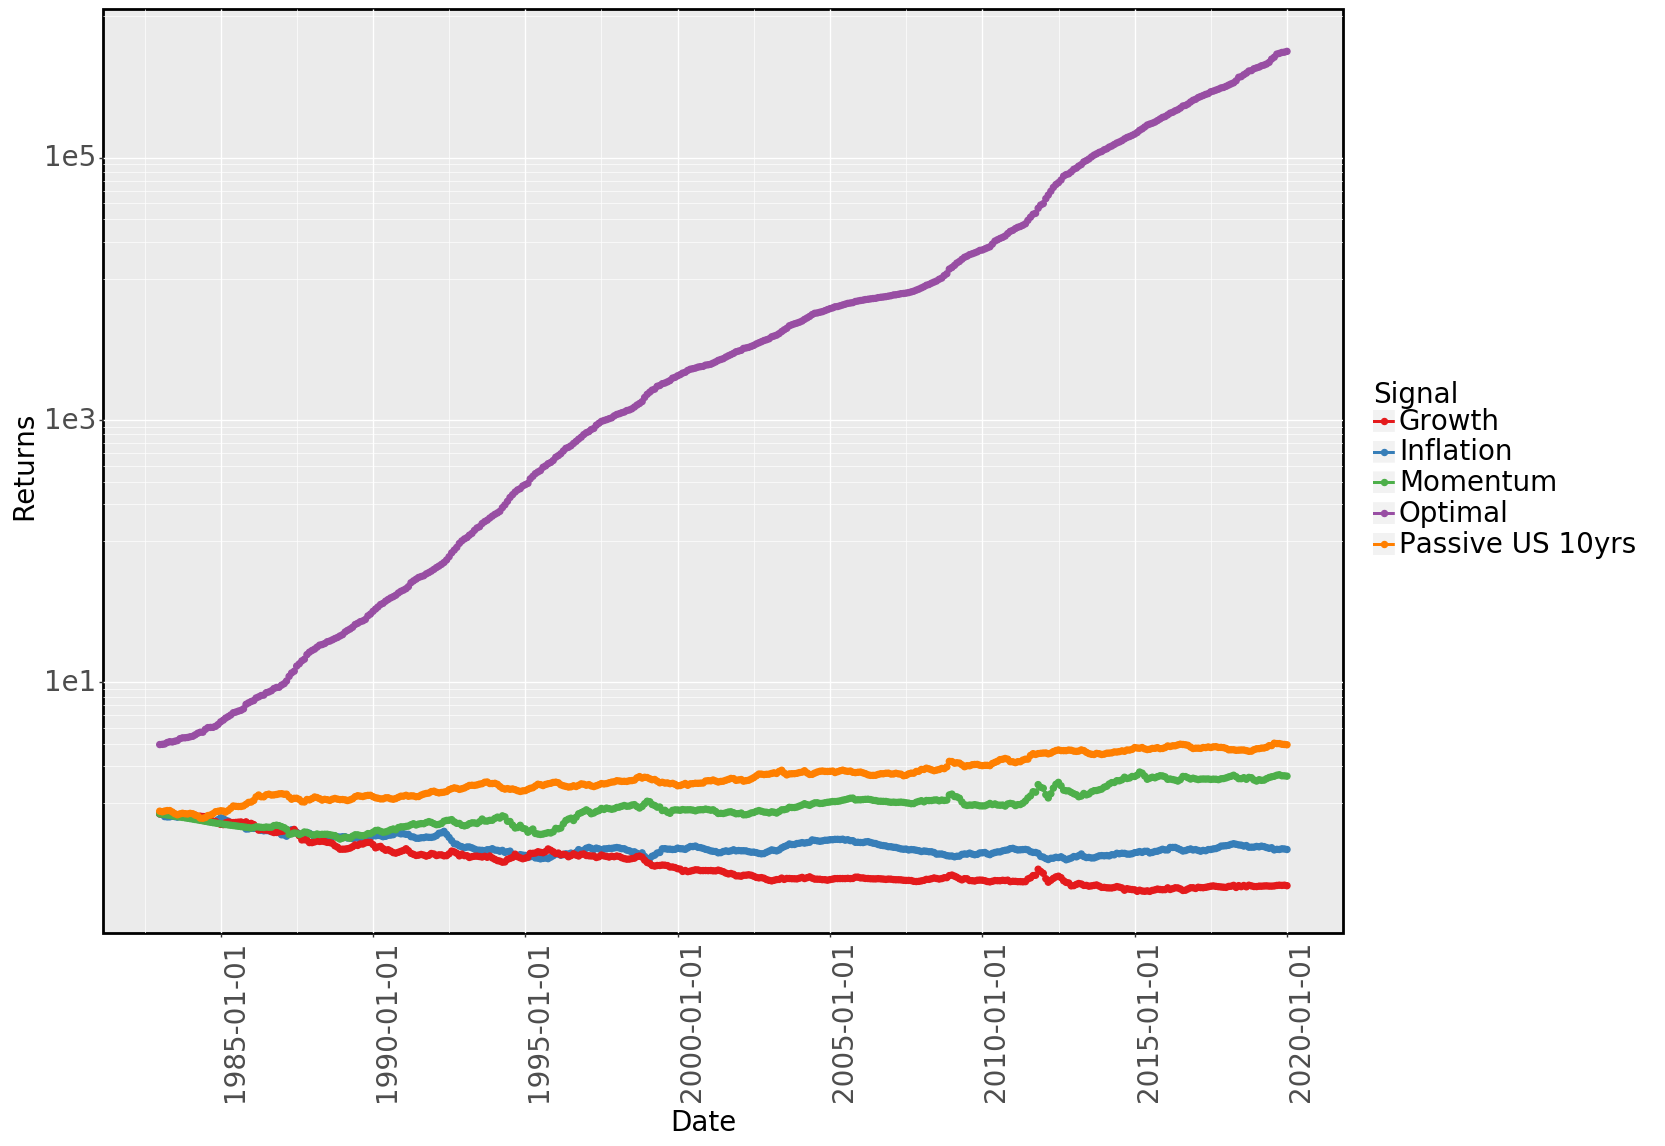

<ggplot: (-9223363243467060329)>

In [32]:

df = {
    'Inflation': inflation_returns,
    'Growth': growth_returns,
    'Momentum': momentum_returns,

    'Optimal': optimal_returns,
    'Passive US 10yrs': passive_10yrs,
}
# for i in range(5):
#     df[f'random {i}'] = calc_signal_returns(bond_returns, get_random_signal(bond_returns))
df = pd.DataFrame(df)
df['date'] = df.index.to_series().map(lambda x: x.to_timestamp())
df = df.melt(id_vars='date')
df['color'] = df['variable'].map(lambda x: x.split()[0] if 'random' in x else x)
(
    ggplot(df, aes(x='date', y='value', color='color')) +
        geom_line(aes(group='variable')) +
        geom_point(aes(group='variable'), size=2) +
        scale_color_brewer(type='qualitative', palette=6) +
        ylab('Returns') +
        xlab('Date') +
        scale_x_date() +
        scale_y_log10() +
        labs(color='Signal') +
        theme(
            text=element_text(size=20),
            figure_size=(16, 12),
            legend_position='right',
            axis_text_x=element_text(size=20, angle=90, hjust=0),
            panel_border=element_rect(colour="black", size=2),
        )
)

In [111]:
# Combination Signals

combo1_sig = signalize(1 * inflation_sig + 1 * growth_sig + 2 * momentum_sig)
combo1_returns = calc_signal_risk_adj_returns(bond_returns, cash_rate, combo1_sig)
print('Combo 1 RAR', combo1_returns.iloc[-1])
print(' - Sharpe Ration Combo 1:', sharpe_ratio(bond_returns, cash_rate, combo1_sig))
print(' - US 10yr Correlation w/ Combo 1:', pearsonr(passive_10yrs.pct_change().iloc[1:], combo1_returns.pct_change().iloc[1:])[0])

combo2_sig = signalize(1 * inflation_sig + 0 * growth_sig + 1 * momentum_sig)
pick_growth = growth_sig.apply(extremity, axis=1) > 1.4 * combo2_sig.apply(extremity, axis=1)
combo2_sig[pick_growth] = growth_sig[pick_growth]
combo2_returns = calc_signal_risk_adj_returns(bond_returns, cash_rate, combo2_sig)
print('Combo 2 RAR', combo2_returns.iloc[-1])
print(' - Growth Picks (%)', 100 * pick_growth.sum() / pick_growth.shape[0])

combo3_sig = signalize(1 * inflation_sig + 1 * growth_sig + 2 * momentum_sig)
signal_weights = combo3_sig.apply(extremity, axis=1)
signal_weights **= 0.5
combo3_sig = (combo3_sig.T * signal_weights).T
combo3_returns = calc_signal_risk_adj_returns(bond_returns, cash_rate, combo3_sig, signal_weights=signal_weights)
print('Combo 3 RAR', combo3_returns.iloc[-1])

combo4_sig = signalize(1 * inflation_sig + 1 * growth_sig + 2 * momentum_sig)
signal_weights = signalize(5 * inflation_sig + -1 * growth_sig).apply(extremity, axis=1)
combo4_sig = (combo4_sig.T * signal_weights).T
combo4_returns = calc_signal_risk_adj_returns(bond_returns, cash_rate, combo4_sig, signal_weights=signal_weights)
print('Combo 4 RAR', combo4_returns.iloc[-1])

combo5_sig = signalize(1 * inflation_sig + 1 * growth_sig + 2 * momentum_sig)
signal_weights = 1 - momentum_sig.apply(extremity, axis=1)
combo5_sig = (combo5_sig.T * signal_weights).T
combo5_returns = calc_signal_risk_adj_returns(bond_returns, cash_rate, combo5_sig, signal_weights=signal_weights)
print('Combo 5 RAR', combo5_returns.iloc[-1])

combo6_sig = signalize(1 * inflation_sig + 1 * growth_sig + 2 * momentum_sig)
signal_weights = combo6_sig.apply(extremity, axis=1)
signal_weights = signal_weights.rolling(3).mean().apply(lambda x: 1 if x > 0.8 else 0)
combo6_sig = (combo6_sig.T * signal_weights).T
combo6_returns = calc_signal_risk_adj_returns(bond_returns, cash_rate, combo6_sig, signal_weights=signal_weights)
print('Combo 6 RAR', combo6_returns.iloc[-1])
print(' - Sharpe Ration Combo 6:', sharpe_ratio(bond_returns, cash_rate, combo6_sig, signal_weights=signal_weights))
print(' - US 10yr Correlation w/ Combo 6:', pearsonr(passive_10yrs.pct_change().iloc[1:], combo6_returns.pct_change().iloc[1:])[0])


Combo 1 RAR 5.143129088832841
 - Sharpe Ration Combo 1: 0.15921839195708853
 - US 10yr Correlation w/ Combo 1: 0.10650111395650977
Combo 2 RAR 1.8775872377390452
 - Growth Picks (%) 0.898876404494382
Combo 3 RAR 4.388559206715086
Combo 4 RAR 2.959161612427857
Combo 5 RAR 0.7689399468439398
Combo 6 RAR 5.951925687986044
 - Sharpe Ration Combo 6: 0.17517488632386907
 - US 10yr Correlation w/ Combo 6: 0.10624452587948101


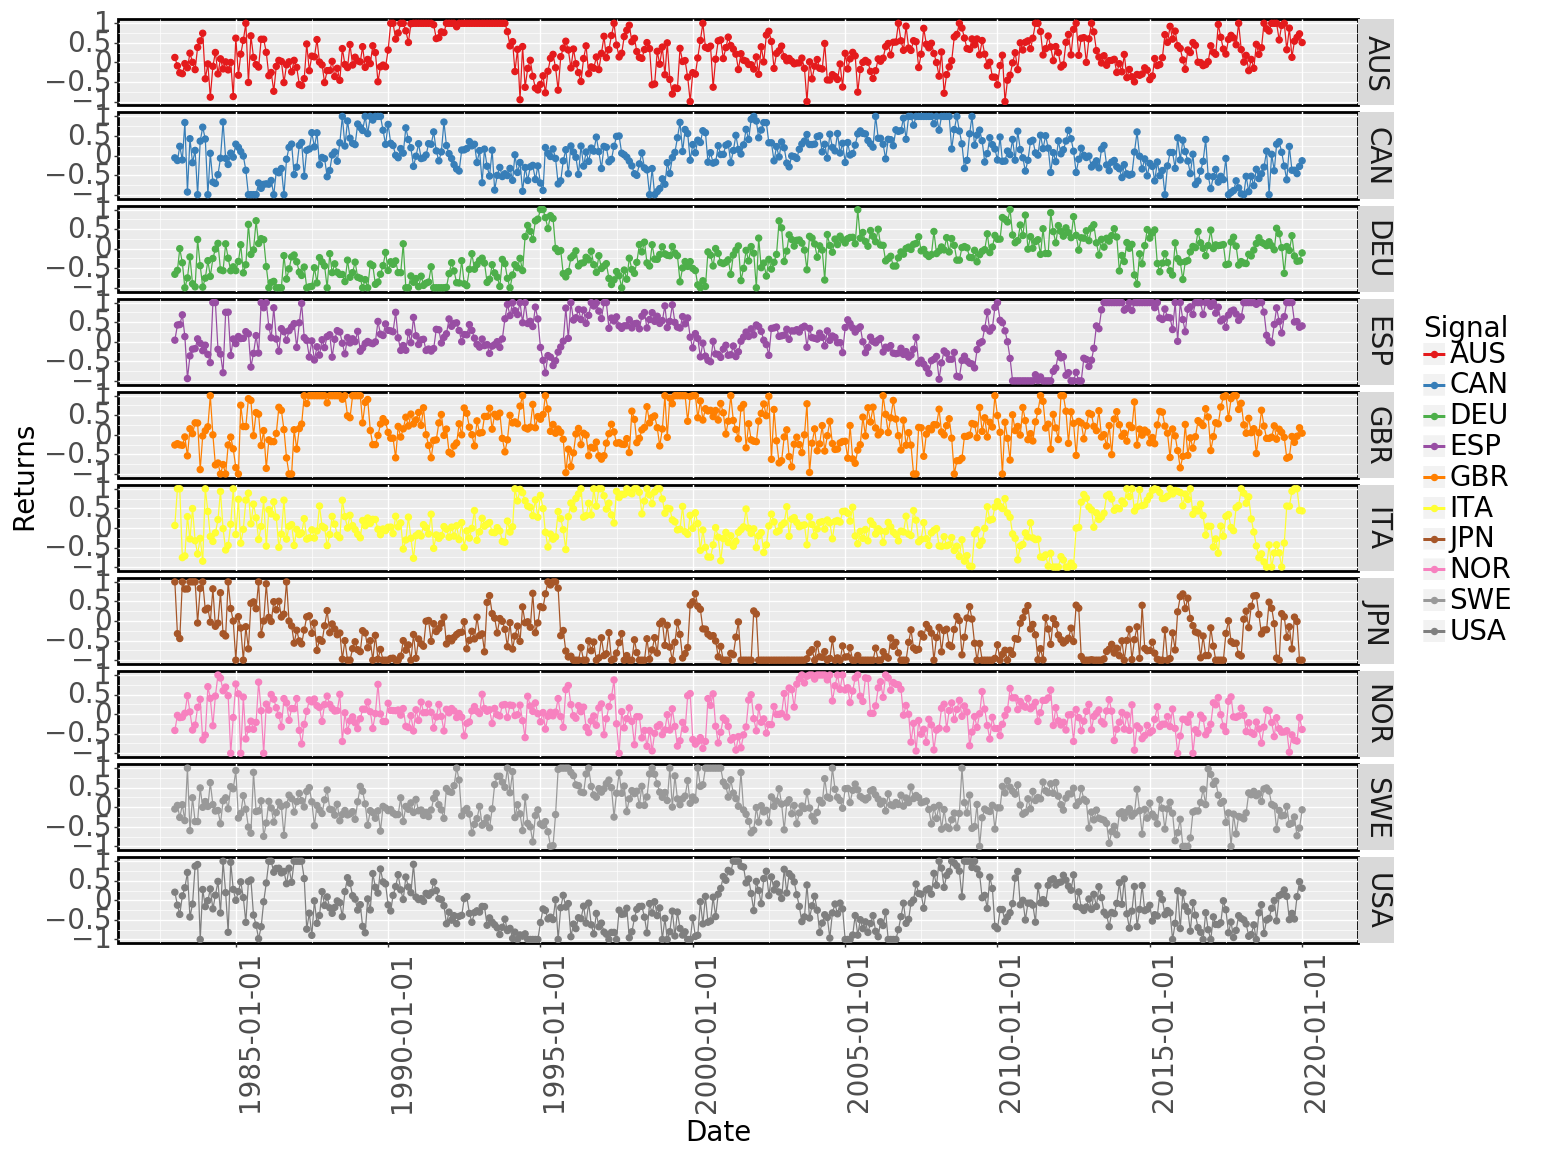

<ggplot: (8793340274973)>

In [112]:
foo = combo1_sig.copy()
foo['date'] = foo.index.to_timestamp()
foo = foo.melt(id_vars='date')

(
    ggplot(foo, aes(x='date', y='value', color='country')) +
        geom_line() +
        geom_point(size=2) +
        scale_color_brewer(type='qualitative', palette=6) +
        facet_grid('country~.') +
        ylab('Returns') +
        xlab('Date') +
        scale_x_date() +

        labs(color='Signal') +
        theme(
            text=element_text(size=20),
            figure_size=(16, 12),
            legend_position='right',
            axis_text_x=element_text(size=20, angle=90, hjust=0),
            panel_border=element_rect(colour="black", size=2),
        )
)



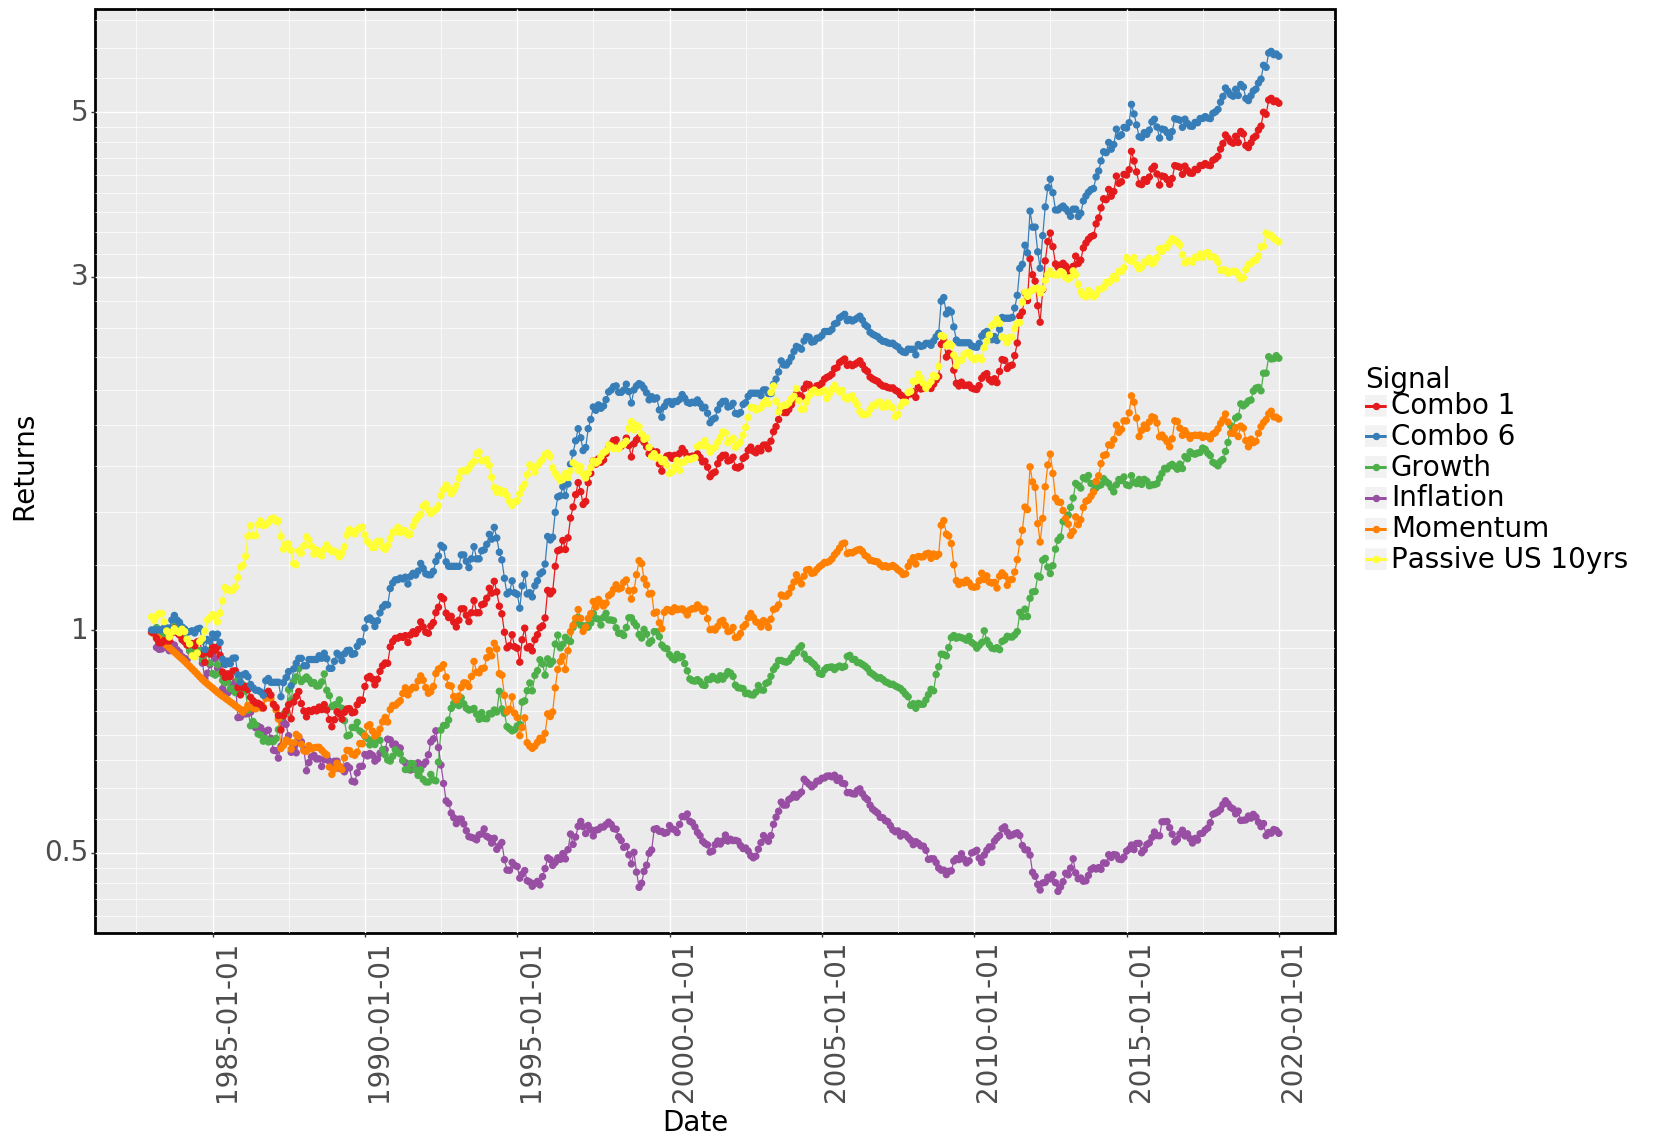

<ggplot: (8793373433159)>

In [113]:
df = {
    'Inflation': inflation_returns,
    'Growth': growth_returns,
    'Momentum': momentum_returns,
    
    'Combo 1': combo1_returns,
    #'Combo 2': combo2_returns,
    #'Combo 3': combo3_returns,
    'Combo 6': combo6_returns,

    #'Optimal': optimal_returns,
    'Passive US 10yrs': passive_10yrs,
}
# for i in range(5):
#     df[f'random {i}'] = calc_signal_returns(bond_returns, get_random_signal(bond_returns))
df = pd.DataFrame(df)
df['date'] = df.index.to_series().map(lambda x: x.to_timestamp())
df = df.melt(id_vars='date')
df['color'] = df['variable'].map(lambda x: x.split()[0] if 'random' in x else x)
(
    ggplot(df, aes(x='date', y='value', color='color')) +
        geom_line(aes(group='variable')) +
        geom_point(aes(group='variable'), size=2) +
        scale_color_brewer(type='qualitative', palette=6) +
        ylab('Returns') +
        xlab('Date') +
        scale_x_date() +
        scale_y_log10() +
        labs(color='Signal') +
        theme(
            text=element_text(size=20),
            figure_size=(16, 12),
            legend_position='right',
            axis_text_x=element_text(size=20, angle=90, hjust=0),
            panel_border=element_rect(colour="black", size=2),
        )
)

In [50]:
def one_trial(dlib, mask, start_date, end_date):
    bond_returns, cash_rate, optimal_returns, passive_10yrs = get_setup(dlib, mask, start_date, end_date)
    momentum_sig, momentum_returns = get_momentum(bond_returns, start_date, end_date)
    growth_sig, growth_returns = get_growth(dlib, mask, start_date, end_date)
    inflation_sig, inflation_returns = get_inflation(dlib, mask, start_date, end_date)
    
    combo1_sig = signalize(1 * inflation_sig + 1 * growth_sig + 2 * momentum_sig)
    combo1_returns = calc_signal_risk_adj_returns(bond_returns, cash_rate, combo1_sig)
    print('Combo 1 RAR', combo1_returns.iloc[-1])
    combo1_sharpe = sharpe_ratio(bond_returns, cash_rate, combo1_sig)
    print(' - Sharpe Ration Combo 1:', combo1_sharpe)
    combo1_pearsonr = pearsonr(passive_10yrs.pct_change().iloc[1:], combo1_returns.pct_change().iloc[1:])[0]
    print(' - US 10yr Correlation w/ Combo 1:', combo1_pearsonr)
    
    combo6_sig = signalize(1 * inflation_sig + 1 * growth_sig + 2 * momentum_sig)
    signal_weights = combo6_sig.apply(extremity, axis=1)
    signal_weights = signal_weights.rolling(3).mean().apply(lambda x: 1 if x > 0.8 else 0)
    combo6_sig = (combo6_sig.T * signal_weights).T
    combo6_returns = calc_signal_risk_adj_returns(bond_returns, cash_rate, combo6_sig, signal_weights=signal_weights)
    print('Combo 6 RAR', combo6_returns.iloc[-1])
    combo6_sharpe = sharpe_ratio(bond_returns, cash_rate, combo6_sig, signal_weights=signal_weights)
    print(' - Sharpe Ration Combo 6:', combo6_sharpe)
    combo6_pearsonr = pearsonr(passive_10yrs.pct_change().iloc[1:], combo6_returns.pct_change().iloc[1:])[0]
    print(' - US 10yr Correlation w/ Combo 6:', combo6_pearsonr)
    
    return {
        'combo_1': (combo1_returns.iloc[-1], combo1_sharpe, combo1_pearsonr),
        'combo_6': (combo6_returns.iloc[-1], combo6_sharpe, combo6_pearsonr),
    }
    
one_trial(dlib, mask, START_DATE, END_DATE)

Net Momentum RAR 1.9266483464224644
Net GDP RAR 0.15878142959003094
Net Equity RAR 0.4962585201411268
GDP Picks (%) 17.078651685393258
Net Growth RAR 0.2813891373655335
Net M2 RAR 0.3036495961245047
Net CPI RAR 0.4245303976748969
Net FX RAR 0.40547000751921825
Net Inflation RAR 0.5313300771122954
Combo 1 RAR 2.3281677464562143
 - Sharpe Ration Combo 1: 0.08962378914701674
 - US 10yr Correlation w/ Combo 1: 0.16353576151801716
Combo 6 RAR 2.9369761416762934
 - Sharpe Ration Combo 6: 0.11830149092811433
 - US 10yr Correlation w/ Combo 6: 0.16470066210000578


{'combo_1': (2.3281677464562143, 0.08962378914701674, 0.16353576151801716),
 'combo_6': (2.9369761416762934, 0.11830149092811433, 0.16470066210000578)}

In [76]:
COUNTRIES = ['JPN', 'CAN', 'ESP', 'DEU', 'ITA', 'GBR', 'NOR', 'AUS', 'USA', 'SWE']
TIMES = [
    1985,
    1990,
    1995,
    2000,
    2005,
    2010,
]


tbl = {}
for _ in range(100):
    countries = list(set(random.choices(COUNTRIES, k=8)) | set(['USA']))
    print(countries)
    for time in TIMES:
        print(f'{time}-01-01')
        def my_mask(tbl):
            tbl = tbl[countries]
            tbl = tbl.loc[f'{time - 3}-01-01':f'{time + 10}-01-01']
            return tbl
        
        out = one_trial(dlib, my_mask, f'{time}-01-01', f'{time + 10}-01-01')
        for k, v in out.items():
            tbl[(tuple(sorted(countries)), time, k)] = v

tbl = pd.DataFrame.from_dict(tbl, orient='index', columns=['return', 'sharpe', 'correlation'])

['DEU', 'ITA', 'SWE', 'JPN', 'USA']
1985-01-01
Net Momentum RAR 0.580863746418013
Net GDP RAR 0.2817233465710657
Net Equity RAR 0.39689079454861326
GDP Picks (%) 38.01652892561984
Net Growth RAR 0.32112506248598777
Net M2 RAR 0.2740848711269465
Net CPI RAR 0.3071392069106184
Net FX RAR 0.3497011823490809
Net Inflation RAR 0.38933195779783586
Combo 1 RAR 0.70626032604677
 - Sharpe Ration Combo 1: -0.13567051541275793
 - US 10yr Correlation w/ Combo 1: 0.08637850660060804
Combo 6 RAR 0.6778727526223892
 - Sharpe Ration Combo 6: -0.15868086668371154
 - US 10yr Correlation w/ Combo 6: 0.04786698786406242
1990-01-01
Net Momentum RAR 0.9855744947289048
Net GDP RAR 0.1943055258654593
Net Equity RAR 0.39943264856675886
GDP Picks (%) 35.53719008264463
Net Growth RAR 0.3233578774180898
Net M2 RAR 0.31593976191911305
Net CPI RAR 0.2880203229967153
Net FX RAR 0.39389533928720577
Net Inflation RAR 0.40021916932934903
Combo 1 RAR 1.3297357072825815
 - Sharpe Ration Combo 1: 0.1153596515851846
 - US 

In [77]:
tbl

,return,sharpe,correlation
"((DEU, ITA, JPN, SWE, USA), 1985, combo_1)",0.706260,-0.135671,0.086379
"((DEU, ITA, JPN, SWE, USA), 1985, combo_6)",0.677873,-0.158681,0.047867
"((DEU, ITA, JPN, SWE, USA), 1990, combo_1)",1.329736,0.115360,0.096265
"((DEU, ITA, JPN, SWE, USA), 1990, combo_6)",1.422940,0.142671,0.075257
"((DEU, ITA, JPN, SWE, USA), 1995, combo_1)",1.149862,0.073681,0.168150
...,...,...,...
"((ESP, GBR, JPN, USA), 2000, combo_6)",1.124028,0.077915,0.471921
"((ESP, GBR, JPN, USA), 2005, combo_1)",1.308531,0.121424,0.476553
"((ESP, GBR, JPN, USA), 2005, combo_6)",1.276878,0.115242,0.437306
"((ESP, GBR, JPN, USA), 2010, combo_1)",1.229074,0.109832,0.158853


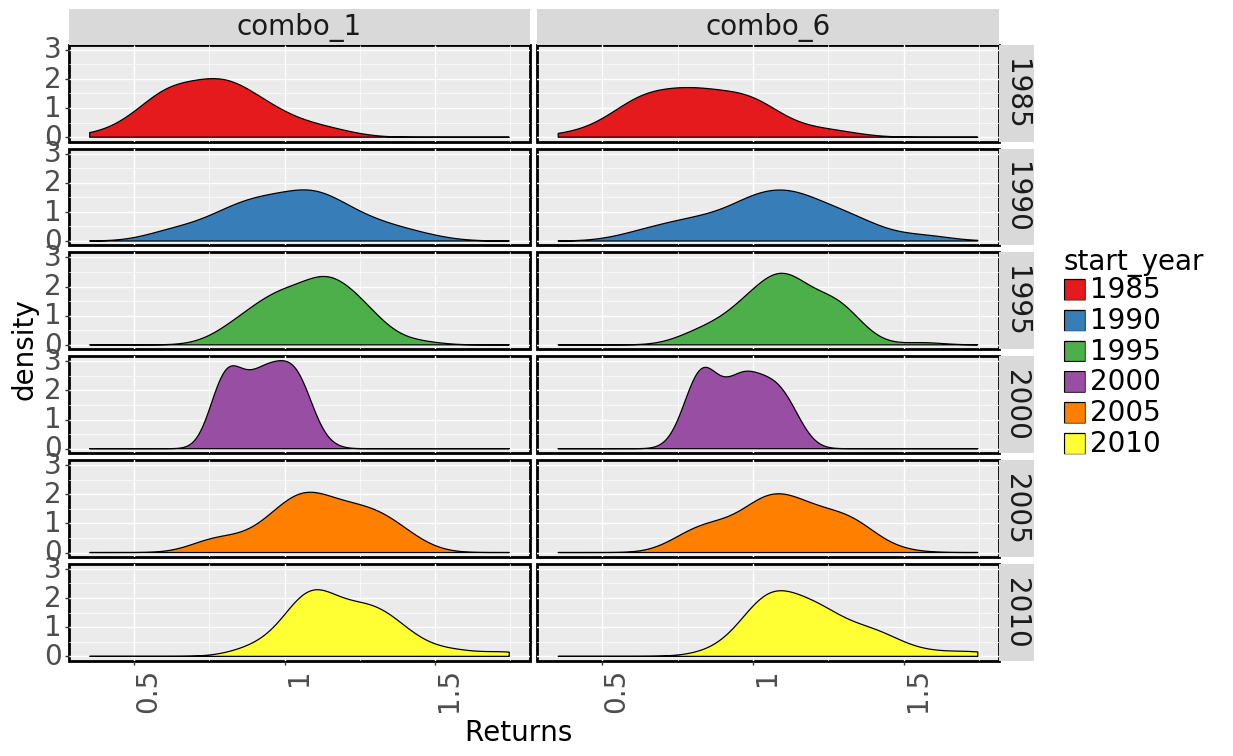

<ggplot: (8793388767296)>

In [78]:
t = tbl.copy()
t['start_year'] = tbl.index.map(lambda x: str(x[1]))
t['method'] = tbl.index.map(lambda x: str(x[2]))
(
    ggplot(t, aes(x='return', fill='start_year')) +
        geom_density() +
        facet_grid('start_year~method') +
        scale_fill_brewer(type='qualitative', palette=6) +
        xlab('Returns') +
        theme(
            text=element_text(size=20),
            figure_size=(12, 8),
            legend_position='right',
            axis_text_x=element_text(size=20, angle=90, hjust=0),
            panel_border=element_rect(colour="black", size=2),
        )
)

In [109]:
# Growth

def get_gdp(dlib, mask, start_date, end_date):
    gdp = mask(dlib.pull('GDP-Real'))
    gdp = gdp.resample('M').pad()
    gdp = derivative(gdp, s=1).rolling(3).mean()
    gdp = center_scale_using_historical_rolling(gdp, window=24, gap=1)
    gdp *= -1
    gdp_sig = signalize(gdp).fillna(0)
    gdp_sig = gdp_sig.loc[start_date:end_date]
    gdp_returns = calc_signal_risk_adj_returns(bond_returns, cash_rate, gdp_sig)
    print('Net GDP RAR', gdp_returns.iloc[-1])
    return gdp_sig, gdp_returns

def get_eqs(dlib, mask, start_date, end_date):
    eqs = mask(dlib.pull('EquityPrices'))
    eqs = eqs.resample('M').mean()
    eqs = eqs.rolling(12).apply(lambda x: (x[11] - x[10])/ x[:11].max()).applymap(lambda x: x - 1)
    eqs_sig = signalize(eqs).fillna(0)
    eqs_sig = eqs_sig.loc[start_date:end_date]
    eqs_returns = calc_signal_risk_adj_returns(bond_returns, cash_rate, eqs_sig)
    print('Net Equity RAR', eqs_returns.iloc[-1])
    return eqs_sig, eqs_returns

def get_growth(dlib, mask, start_date, end_date):
    gdp_sig, gdp_returns = get_gdp(dlib, mask, start_date, end_date)
    eqs_sig, eqs_returns = get_eqs(dlib, mask, start_date, end_date)
    pick_gdp = gdp_sig.apply(extremity, axis=1) > eqs_sig.apply(extremity, axis=1)
    print('GDP Picks (%)', 100 * pick_gdp.sum() / pick_gdp.shape[0])
    growth_sig = eqs_sig.copy()
    growth_sig[pick_gdp] = gdp_sig[pick_gdp]

    growth_returns = calc_signal_risk_adj_returns(bond_returns, cash_rate, growth_sig)
    print('Net Growth RAR', growth_returns.iloc[-1])
    return growth_sig, growth_returns

growth_sig, growth_returns = get_growth(dlib, mask, START_DATE, END_DATE)

Net GDP RAR 0.3918908667895453
Net Equity RAR 2.533471857950537
GDP Picks (%) 15.955056179775282
Net Growth RAR 2.327495623508982


Net Equity RAR 2.533471857950537
Net GDP RAR 0.3918908667895453
Net Equity RAR 2.533471857950537
GDP Picks (%) 15.955056179775282
Net Growth RAR 2.327495623508982
Net GDP RAR 0.3918908667895453


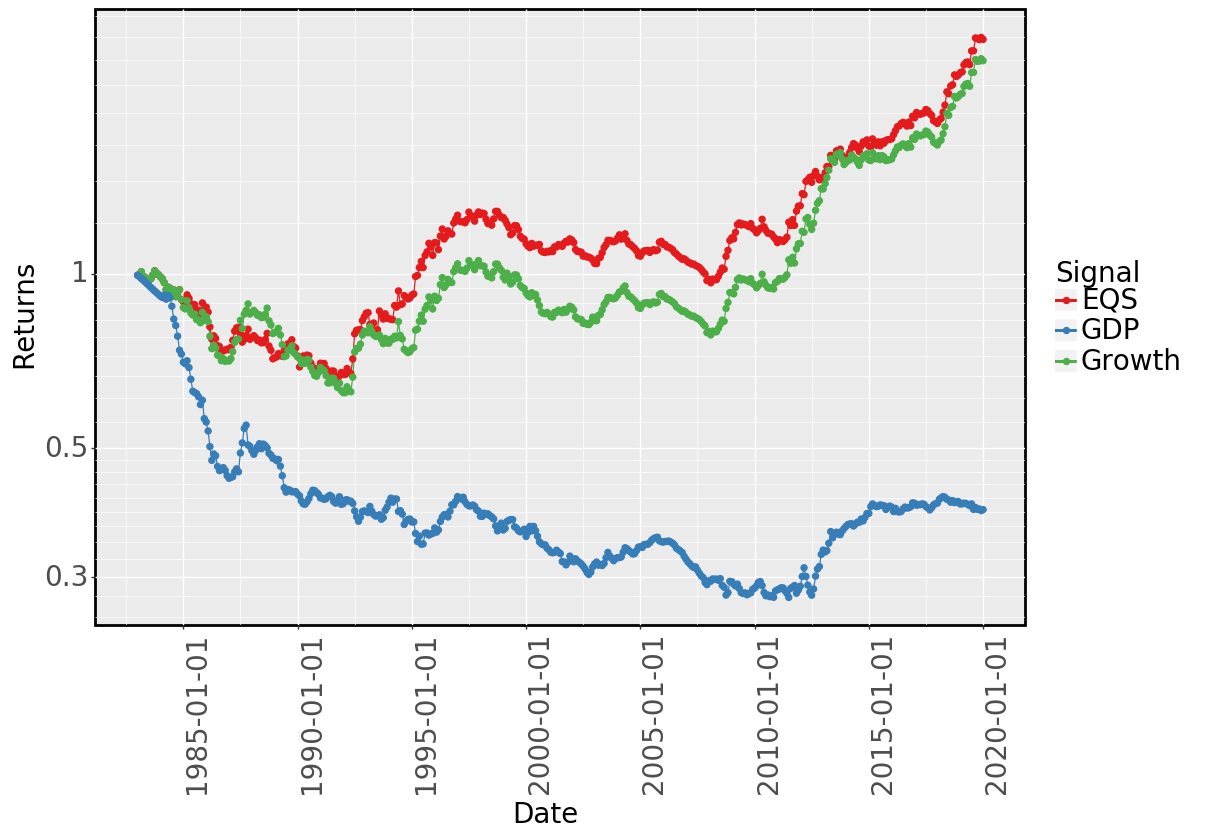

<ggplot: (-9223363243514338770)>

In [110]:
df = {
    'EQS': get_eqs(dlib, mask, START_DATE, END_DATE)[1],
    'Growth': get_growth(dlib, mask, START_DATE, END_DATE)[1],
    'GDP': get_gdp(dlib, mask, START_DATE, END_DATE)[1],
}
df = pd.DataFrame(df)
df['date'] = df.index.to_series().map(lambda x: x.to_timestamp())
df = df.melt(id_vars='date')
(
    ggplot(df, aes(x='date', y='value', color='variable')) +
        geom_line(aes(group='variable')) +
        geom_point(aes(group='variable'), size=2) +
        scale_color_brewer(type='qualitative', palette=6) +
        ylab('Returns') +
        xlab('Date') +
        scale_x_date() +
        scale_y_log10() +
        labs(color='Signal') +
        theme(
            text=element_text(size=20),
            figure_size=(12, 8),
            legend_position='right',
            axis_text_x=element_text(size=20, angle=90, hjust=0),
            panel_border=element_rect(colour="black", size=2),
        )
)

In [99]:
df

,date,variable,value
0,1983-01-01,EQS,0.993488
1,1983-02-01,EQS,0.986114
2,1983-03-01,EQS,0.995929
3,1983-04-01,EQS,0.988870
4,1983-05-01,EQS,0.985867
...,...,...,...
1330,2019-09-01,GDP,0.159096
1331,2019-10-01,GDP,0.159802
1332,2019-11-01,GDP,0.159209
1333,2019-12-01,GDP,0.159789
